In [11]:
% matplotlib 

Using matplotlib backend: Qt5Agg


In [12]:
% matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import datetime
import time
from datetime import datetime, date

In [20]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import  SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import  SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.grid_search import GridSearchCV 

### 讀取csv檔：

In [326]:
dataset = pd.read_csv('1127.csv')

In [327]:
dataset.columns

Index(['x', 'R', 'T1', 'T2', 'T3', 'T4', 'T5', 'speed', 'env_T', 'env_hum',
       'set_T1', 'set_T2', 'set_T3', 'set_T4', 'set_T5', 'piece', 'position',
       'time', 'ok'],
      dtype='object')

In [328]:
c320 = 19.05
dataset['R'] = (c320**2 + dataset['x']**2)/(2*dataset['x'])

In [329]:
dataset.head(1)

,x,R,T1,T2,T3,T4,T5,speed,env_T,env_hum,set_T1,set_T2,set_T3,set_T4,set_T5,piece,position,time,ok
0,0.572,317.508465,580,736,722,621,488,32.34,29,13,750,735,722,621,500,1,1,2017/11/27 11:45,1


### 選擇任務範圍:

In [330]:
dataset = dataset.drop(['x','time','set_T1', 'set_T2', 'set_T3', 'set_T4', 'set_T5'
                       ], axis = 1)

In [331]:
dataset.columns

Index(['R', 'T1', 'T2', 'T3', 'T4', 'T5', 'speed', 'env_T', 'env_hum', 'piece',
       'position', 'ok'],
      dtype='object')

In [332]:
dataset.head(1)

,R,T1,T2,T3,T4,T5,speed,env_T,env_hum,piece,position,ok
0,317.508465,580,736,722,621,488,32.34,29,13,1,1,1


In [333]:
len(dataset)

336

In [334]:
data_ok = dataset[dataset['ok']==1]
data_ok = data_ok[data_ok['speed']<30 ]

In [335]:
data_ok.loc[data_ok.index[0]] 

R           327.806332
T1          632.000000
T2          690.000000
T3          683.000000
T4          593.000000
T5          441.000000
speed        22.380000
env_T        26.000000
env_hum      14.000000
piece         2.000000
position      1.000000
ok            1.000000
Name: 192, dtype: float64

In [336]:
columns = ['R', 'T1', 'T2', 'T3', 'T4', 'T5', 'speed', 'env_T', 'env_hum', 'piece',
       'position', 'ok']
df = pd.DataFrame(np.array(np.zeros([24*2,12])), columns=columns)
df.index = list(range(24*2))

In [214]:
for i in range(24):
    data_ok.loc[2+] 
    df.T1[3+6*i]= df2[i+1][5]

SyntaxError: unexpected EOF while parsing (<ipython-input-214-af3990adb3d7>, line 2)

In [337]:
data_ok.describe()

,R,T1,T2,T3,T4,T5,speed,env_T,env_hum,piece,position,ok
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000,120.000000,120.000000,120.0
mean,325.188492,626.000000,722.250000,712.250000,614.000000,450.450000,2.238000e+01,26.300000,14.300000,3.000000,3.500000,1.0
std,7.706089,12.875617,19.018456,16.958303,12.175192,5.658117,6.778459e-14,0.460179,0.460179,2.289912,1.714986,0.0
min,311.528636,598.000000,690.000000,683.000000,593.000000,441.000000,2.238000e+01,26.000000,14.000000,1.000000,1.000000,1.0
25%,319.179491,620.000000,716.250000,712.250000,614.000000,448.500000,2.238000e+01,26.000000,14.000000,1.750000,2.000000,1.0
50%,323.723013,632.000000,735.000000,722.000000,621.000000,453.000000,2.238000e+01,26.000000,14.000000,2.000000,3.500000,1.0
75%,330.186364,636.000000,735.000000,722.000000,621.000000,454.000000,2.238000e+01,27.000000,15.000000,3.000000,5.000000,1.0
max,343.921670,636.000000,735.000000,722.000000,621.000000,456.000000,2.238000e+01,27.000000,15.000000,9.000000,6.000000,1.0


In [338]:
X_train, X_test, y_train, y_test = train_test_split(data_ok[data_ok.columns[1:9]],
                     data_ok[data_ok.columns[0]],test_size=0.0,random_state=123)

In [210]:
#ss = StandardScaler()
#X_train = ss.fit_transform(X_train)
#X_test = ss.fit_transform(X_test)

In [339]:
lr = LinearRegression()
lr.fit(X_train, y_train)
#lr_predict = lr.predict(X_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [340]:
lr_train = lr.predict(X_train)

In [342]:
r2_score(y_train, lr_train) 

0.035542204639614328

In [388]:
mean = np.mean(data_ok['R'])
AA = (y_train-lr_train)
BB = (y_train-mean)
1-np.mean(AA**2)/np.mean(BB**2)

0.035542204639614994

In [377]:
columns = ['R', 'T1', 'T2', 'T3', 'T4', 'T5', 'speed', 'env_T', 'env_hum', 'piece',
       'position', 'ok']
df_save = pd.DataFrame(np.array(np.zeros([120,12])), columns=columns)
df_save.index = list(range(120))

In [389]:
CC = AA-BB

In [390]:
np.mean(AA)

1.0705510552118843e-13

In [391]:
np.mean(BB)

-1.2316074086508404e-14

In [393]:
df_save = pd.concat([ AA,BB,CC], axis=1)

In [394]:
df_save.to_csv('df_save.csv')

In [398]:
y_train

196    320.303341
333    322.004074
328    336.913749
320    324.879232
247    321.435155
234    315.854891
326    331.389420
278    333.822092
226    320.303341
251    324.879232
249    319.179491
206    330.186364
197    322.004074
192    327.806332
223    320.868247
293    320.868247
303    318.063521
267    323.723013
310    335.670223
288    336.913749
239    323.147993
301    322.575017
281    321.435155
272    324.879232
269    324.300089
238    320.868247
254    326.629169
229    324.879232
321    315.854891
279    321.435155
          ...    
255    318.063521
300    336.290833
194    330.786795
283    323.723013
271    323.723013
265    326.629169
284    326.629169
296    322.575017
319    324.879232
252    333.822092
294    340.700365
329    318.620526
235    326.629169
324    319.179491
262    317.508465
248    327.806332
289    324.300089
263    325.460452
312    313.136983
313    317.508465
302    323.723013
273    316.955348
322    323.723013
299    326.043760
227    317

In [386]:
print(X_train[abs(AA)>50].sort_index())
#CC[abs(CC)>100].sort_values()
print(len(X_train[abs(AA)>20]))

      T1   T2   T3   T4   T5  speed  env_T  env_hum
205  632  690  683  593  441  22.38     26       14
207  632  690  683  593  441  22.38     26       14
208  632  690  683  593  441  22.38     26       14
209  632  690  683  593  441  22.38     26       14
222  632  690  683  593  441  22.38     26       14
224  632  690  683  593  441  22.38     26       14
225  632  690  683  593  441  22.38     26       14
227  632  690  683  593  441  22.38     26       14
228  632  690  683  593  441  22.38     26       14
230  632  690  683  593  441  22.38     26       14
231  632  690  683  593  441  22.38     26       14
234  632  690  683  593  441  22.38     26       14
236  632  690  683  593  441  22.38     26       14
237  632  690  683  593  441  22.38     26       14
246  636  725  722  621  451  22.38     27       14
250  636  725  722  621  451  22.38     27       14
252  636  725  722  621  451  22.38     27       14
258  636  725  722  621  451  22.38     27       14
261  636  72

In [361]:
X_train, X_test, y_train, y_test = train_test_split(data_ok[data_ok.columns[1:9]],
                     data_ok[data_ok.columns[0]],test_size=0.0,random_state=123)

In [362]:
(X_train).shape

(120, 8)

In [367]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)

In [368]:
X_train_poly.shape

(120, 165)

In [369]:
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                 ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train, y_train)
# model.named_steps['linear'].coef_
poly_train = model.predict(X_train)

In [370]:
print( r2_score(y_train, poly_train)  )

0.0355422046396


In [224]:
print('LR default measure:', lr.score(X_train, y_train))

LR default measure: 0.0122519966731


In [ ]:
print('LR default measure:', lr.score(X_test, y_test))

In [352]:
X_train, X_test, y_train, y_test = train_test_split(data_ok[data_ok.columns[1:9]],
                     data_ok[data_ok.columns[0]],test_size=0.25,random_state=22)

In [353]:
rfr = RandomForestRegressor( bootstrap= False ,n_jobs = -1, n_estimators=100,
                               max_features='sqrt')
rfr.fit(X_train, y_train)
rfr_predict = rfr.predict(X_test)

In [354]:
rfr_train = rfr.predict(X_train)

In [355]:
print( r2_score(y_test, rfr_predict)  )

-0.313620678162


In [356]:
print( r2_score(y_train, rfr_train)  )

0.0798935713542


In [357]:
X_train, X_test, y_train, y_test = train_test_split(data_ok[data_ok.columns[1:9]],
                     data_ok[data_ok.columns[0]],test_size=0.0,random_state=22)
#ss = StandardScaler()
#X_train = ss.fit_transform(X_train)
#X_test = ss.fit_transform(X_test)

In [358]:
svr = SVR( kernel = 'rbf', C = 2.0, epsilon= 1.0,  gamma = 0.1)
svr.fit(X_train, y_train)
#SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.09,
#  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=1.0, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [360]:
svr_train = svr.predict(X_train)
r2_score(y_train, svr_train )

-0.027289218586723507

In [ ]:
svr_predict = svr.predict(X_test)
r2_score(y_test, svr_predict )

### 切分訓練/測試資料集：

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.2,random_state=22)

In [11]:
print([X_train.shape, X_test.shape, y_train.shape, y_test.shape] )
print(y_train.value_counts())
print(y_test.value_counts())

[(1980, 8), (660, 8), (1980L,), (660L,)]
2    1076
0     458
1     446
Name: category, dtype: int64
2    364
1    154
0    142
Name: category, dtype: int64


### 前處理：

In [12]:
ss = StandardScaler()

In [13]:
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

### 1. 分類任務
### 1.1  以logistic regression作基準：

In [14]:
lr = LogisticRegression(n_jobs=-1)

In [15]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
lr_y_predict = lr.predict(X_test)

In [17]:
#lr_y_predict

### 結論：用最基本的模型做分類，準確度已 100%

In [18]:
print ('LR accuracy:', lr.score(X_test, y_test))

('LR accuracy:', 1.0)


### 1.2 測試SVM:

In [43]:
svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto',
          coef0=0.0, shrinking=True, probability=False,
          tol=0.001, cache_size=200, class_weight=None,
          verbose=False, max_iter=-1, decision_function_shape='ovr',
          random_state=None)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

In [45]:
svc.fit(X_train, y_train)
svc_val_predict = svc.predict(X_test)
#svc_val_predict
print(accuracy_score(y_test, svc_val_predict))

1.0


### 結論：用SVM做分類，準確度也是 100%

### 2. 聚類任務
### 2.1 用K-means聚類

In [19]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=23)

In [20]:
from sklearn.cluster import KMeans

In [21]:
kmeans = KMeans(n_clusters = 5, n_jobs=-1)

In [22]:
kmeans.fit(X_train)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [23]:
y_pred = kmeans.predict(X_test)

In [24]:
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['digit']
df_y_pred.digit.value_counts()

0    371
3    146
2    101
4     37
1      5
Name: digit, dtype: int64

### 用adjusted rand index(ARI)評估聚類結果：

In [25]:
from sklearn import metrics
print (metrics.adjusted_rand_score(y_test, y_pred)  )
#用輪廓係數(silhouette coefficient, sc)來評估聚類效果：
#須定義凝聚度(cohesion)=a 和 分離度(separation)=b
#sc[i] = (b[i]-a[i])/max(b[i],a[i])
# 0<sc<1: 聚類效果好
#-1<sc<0: 聚類效果差

0.946617722774


### 用silhouette_score度量最適合聚類數目：

In [26]:
from sklearn.metrics import silhouette_score

In [27]:
clusters = [2,3,4,5,8]
sc_scores = []
for t in clusters:
    kmeans_model = KMeans(n_clusters = t).fit(X_test)
    sc_score = silhouette_score(X_test, kmeans_model.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
#np.argmax(sc_scores)

#### 對於不同物理量構成的資料，"距離"觀念其實是有問題的（相同溫度差，濕度差，和速率差的無法比較），所以K-means不適用。

### 2.2 用t-SNE看聚類：

In [29]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

In [30]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1980
[t-SNE] Computed conditional probabilities for sample 1980 / 1980
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 0.585949
[t-SNE] Error after 200 iterations: 0.588272
t-SNE done! Time elapsed: 32.4020001888 seconds


In [31]:
colors = y_train
c = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=plt.cm.RdYlGn)

### 3D視覺化

In [35]:
from mpl_toolkits.mplot3d import Axes3D as ax
import random

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:,0],tsne_results[:,1], tsne_results[:,2], s=30, c=y_train)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

### 3. 分群回歸任務

### 4. 淺層神經網路  (略過)

In [8]:
import tensorflow as tf
import numpy as np

In [108]:
sess = tf.Session()

In [109]:
x = tf.placeholder(tf.float32, [None, 30], name = 'input-x')
y_ = tf.placeholder(tf.int32, [None,], name = 'input-y')
lamb = tf.placeholder(tf.float32, name = 'weight_decay')
lr = tf.placeholder(tf.float32, name = 'learning_rate')

weights = tf.Variable(tf.truncated_normal([30,2], mean=0.0, stddev=0.1, dtype=tf.float32),
                name = 'weights')
biases = tf.Variable(tf.constant(0.01, dtype=tf.float32, shape=[2]), name = 'biases')
z = tf.matmul(x, weights) + biases
y = tf.sigmoid(z)

y_one_hot = tf.one_hot(y_, depth = 2)
entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_one_hot, logits = z )
mean_entropy = tf.reduce_mean(entropy)
loss = mean_entropy + lamb* tf.reduce_sum(tf.square(weights))

train_step = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [110]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [111]:
feed_dict = {x: X_train, y_: y_train, lamb: 1e-4, lr: 1e-4  }

In [114]:
for i in range(10000):
    sess.run(train_step, feed_dict = feed_dict)
    if i%1000==0:
        print(sess.run([loss, accuracy], feed_dict = {x: X_train, y_: y_train, lamb:1e-2 }))

[0.13804975, 0.95070422]
[0.13734476, 0.95070422]
[0.13789117, 0.95070422]
[0.13663246, 0.95070422]
[0.13605151, 0.95070422]
[0.13565148, 0.94718313]
[0.13533726, 0.94718313]
[0.13506821, 0.94718313]
[0.13482602, 0.94718313]
[0.13460225, 0.94718313]


In [113]:
print(sess.run(accuracy, feed_dict = {x: X_val, y_: y_val })  )

0.905263


In [9]:
df_0 = dataset[dataset['category']==0]
df_1 = dataset[dataset['category']==1]
df_2 = dataset[dataset['category']==2]
print(df_0.shape, df_1.shape, df_2.shape)
print(600/30, 1440/30)

(600, 10) (600, 10) (1440, 10)
20.0 48.0


In [90]:
df_0.describe()

,speed,env_temp,env_wet,T1,T2,T3,T4,T5,radius,category
count,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000,600.00000,600.00000,600.000000,600.0
mean,33.010000,34.250000,64.925000,580.750000,723.00000,718.250000,618.75000,476.00000,341.383478,0.0
std,1.283353,1.657431,5.905082,13.946745,1.87239,0.829848,2.16687,7.91229,1.940658,0.0
min,32.230000,31.500000,60.000000,565.000000,721.00000,717.000000,615.00000,465.00000,337.038609,0.0
25%,32.237500,33.675000,60.075000,572.500000,721.75000,717.750000,618.75000,470.25000,340.190561,0.0
50%,32.260000,34.950000,62.600000,577.500000,722.50000,718.500000,620.00000,477.50000,341.147702,0.0
75%,33.062500,35.525000,67.450000,585.750000,723.75000,719.000000,620.00000,483.25000,342.432320,0.0
max,35.230000,35.600000,74.500000,603.000000,726.00000,719.000000,620.00000,484.00000,347.005869,0.0


In [ ]:
print(df_0['speed'].value_counts()/30)
print(df_1['speed'].value_counts()/30)
print(df_2['speed'].value_counts()/30)
print(dataset['speed'].value_counts()/30)
print(dataset['speed'].count()/30)

In [ ]:
print(df_0['env_temp'].value_counts()/30)
print(df_1['env_temp'].value_counts()/30)
print(df_2['env_temp'].value_counts()/30)
print(dataset['env_temp'].value_counts()/30)
print(dataset['env_temp'].count()/30) 


In [ ]:
print(df_0['env_wet'].value_counts()/30)
print(df_1['env_wet'].value_counts()/30)
print(df_2['env_wet'].value_counts()/30)
print(dataset['env_wet'].value_counts()/30)
print(dataset['env_wet'].count()/30)

In [30]:
colors = dataset['category']
c1 = plt.scatter(dataset['env_wet'], dataset['env_temp'], c=colors, cmap=plt.cm.RdYlGn)

In [28]:
colors = dataset['category']
c2 = plt.scatter(dataset['env_wet'], dataset['speed'], c=colors, cmap=plt.cm.RdYlGn)

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### analysis of group 1:

In [12]:
df_0.columns

Index(['speed', 'env_temp', 'env_wet', 'T1', 'T2', 'T3', 'T4', 'T5', 'radius',
       'category'],
      dtype='object')

In [98]:
set_tw_0 = df_0[['env_temp','env_wet']]

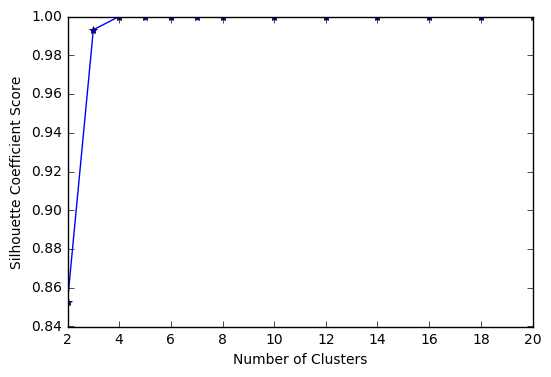

2

In [111]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_tw_0)
    sc_score = silhouette_score(set_tw_0, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [103]:
set_T_0 = df_0[['T1','T2','T3','T4','T5']]

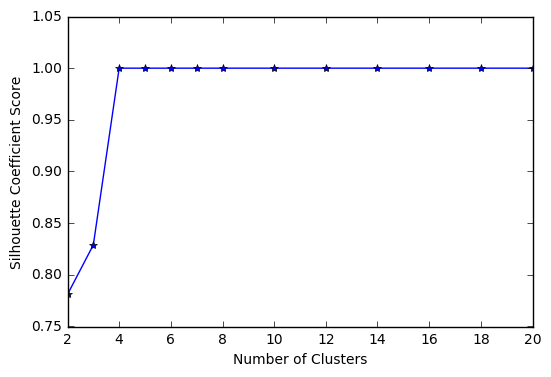

2

In [112]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_T_0)
    sc_score = silhouette_score(set_T_0, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [113]:
set_sT_0 = df_0[['speed','T1','T2','T3','T4','T5']]

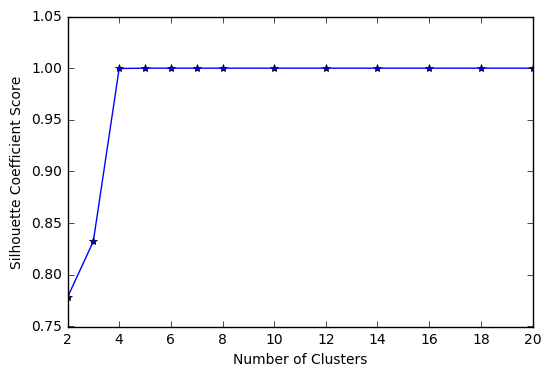

3

In [114]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_sT_0)
    sc_score = silhouette_score(set_sT_0, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [115]:
set_all_0 = df_0[['speed','env_temp','env_wet','T1','T2','T3','T4','T5']]

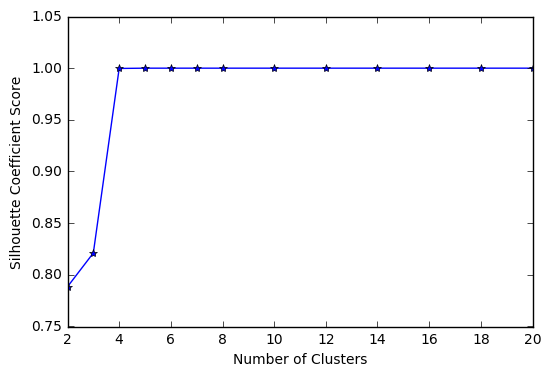

3

In [116]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_all_0)
    sc_score = silhouette_score(set_all_0, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

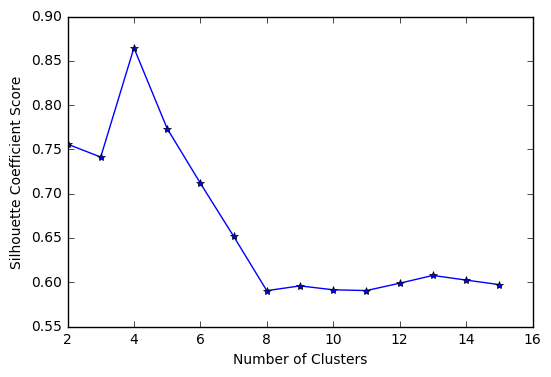

2

In [119]:
clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
sc_scores = []
for t in clusters:
    kmeans_model = KMeans(n_clusters = t).fit(df_0)
    sc_score = silhouette_score(df_0, kmeans_model.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

### analysis of group 2:

In [82]:
df_1.columns

Index(['speed', 'env_temp', 'env_wet', 'T1', 'T2', 'T3', 'T4', 'T5', 'radius',
       'category'],
      dtype='object')

In [17]:
set_tw_1 = df_1[['env_temp','env_wet']]

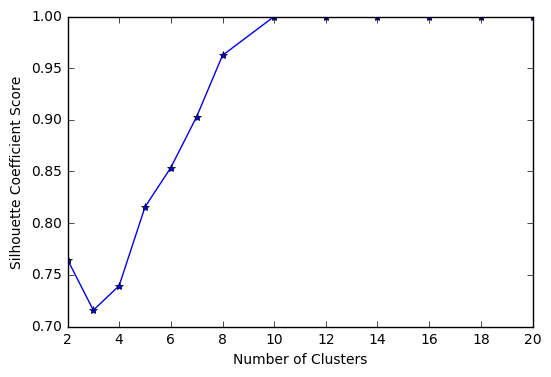

7

In [106]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_tw_1)
    sc_score = silhouette_score(set_tw_1, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [89]:
set_T_1 = df_1[['T1','T2','T3','T4','T5']]

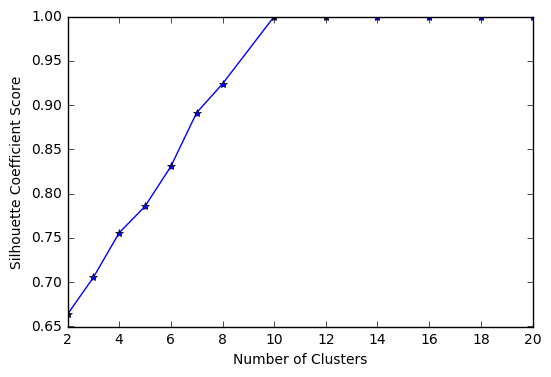

7

In [107]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_T_1)
    sc_score = silhouette_score(set_T_1, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [92]:
set_sT_1 = df_1[['speed','T1','T2','T3','T4','T5']]

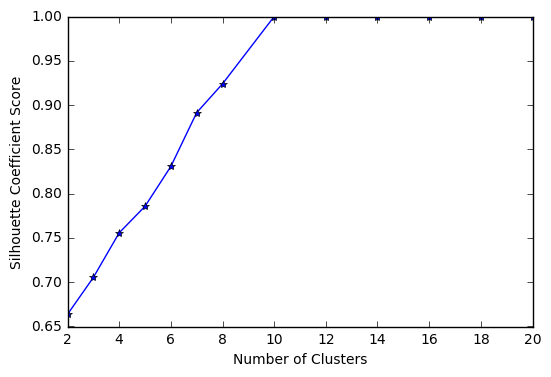

7

In [108]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_sT_1)
    sc_score = silhouette_score(set_sT_1, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [94]:
set_all_1 = df_1[['speed','env_temp','env_wet','T1','T2','T3','T4','T5']]

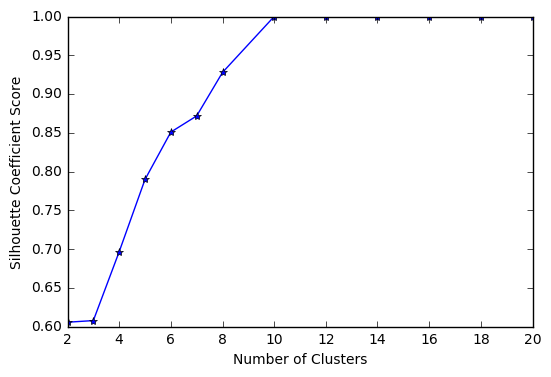

7

In [109]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_all_1)
    sc_score = silhouette_score(set_all_1, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

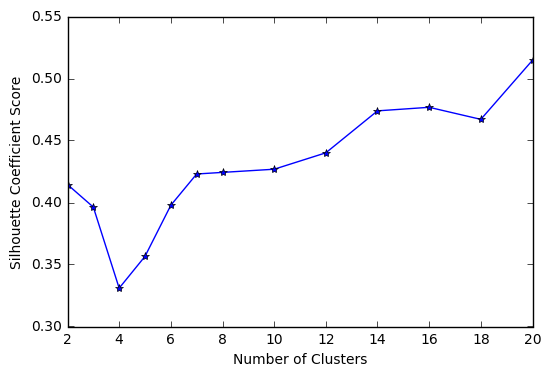

12

In [110]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(df_1)
    sc_score = silhouette_score(df_1, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

### analysis of group 3:

In [109]:
set_tw_2 = df_2[['env_temp','env_wet']]

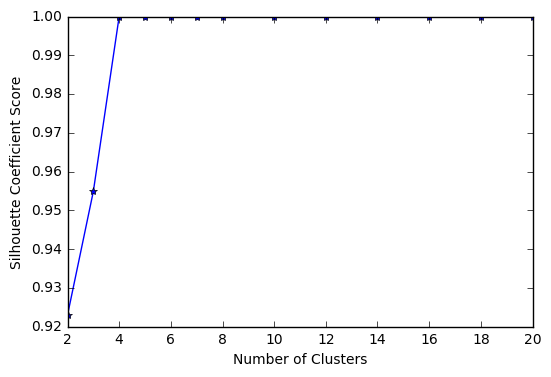

2

In [110]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_tw_2)
    sc_score = silhouette_score(set_tw_2, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [123]:
set_T_2 = df_2[['T1','T2','T3','T4','T5']]

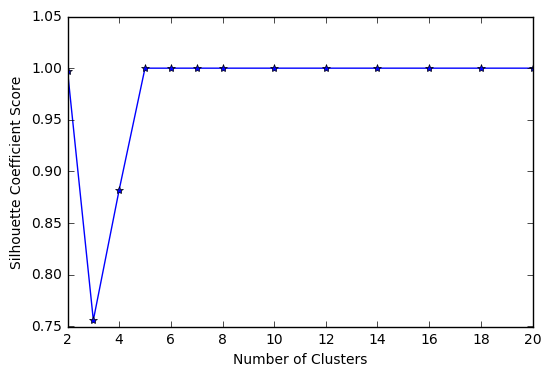

3

In [124]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_T_2)
    sc_score = silhouette_score(set_T_2, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [112]:
set_sT_2 = df_2[['speed','T1','T2','T3','T4','T5']]

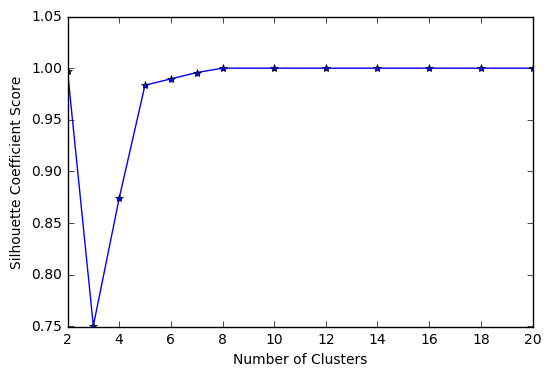

6

In [127]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_sT_2)
    sc_score = silhouette_score(set_sT_2, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [113]:
set_all_2 = df_2[['speed','env_temp','env_wet','T1','T2','T3','T4','T5']]

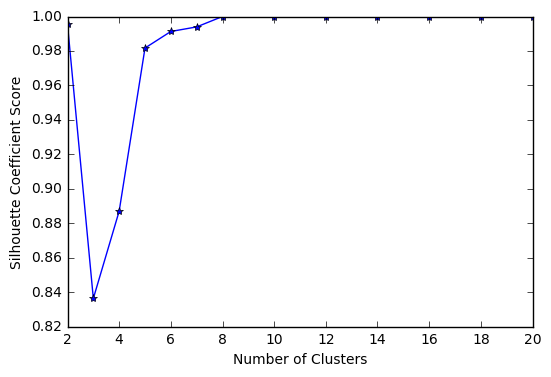

6

In [129]:
clusters = [2,3,4,5,6,7,8,10,12,14,16,18,20]
sc_scores = []
for t in clusters:
    kmeans = KMeans(n_clusters = t).fit(set_all_2)
    sc_score = silhouette_score(set_all_2, kmeans.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
np.argmax(sc_scores)

In [115]:
df_2.columns

Index(['speed', 'env_temp', 'env_wet', 'T1', 'T2', 'T3', 'T4', 'T5', 'radius',
       'category'],
      dtype='object')

In [68]:
len(df_2)/30

48.0

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_2[df_2.columns[0:8]],
                     df_2[df_2.columns[9]],test_size=0.25,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

#print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 0.100335
[t-SNE] Error after 250 iterations: 0.093115


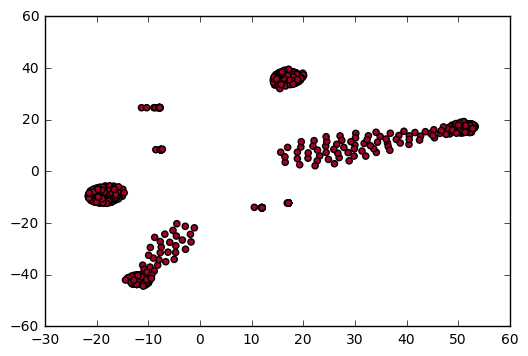

In [73]:
colors = y_train
c = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=plt.cm.RdYlGn)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(set_all_1,
                     df_1['category'],test_size=0.2,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

#print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 480 / 480
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 1.131364
[t-SNE] Error after 250 iterations: 0.946256


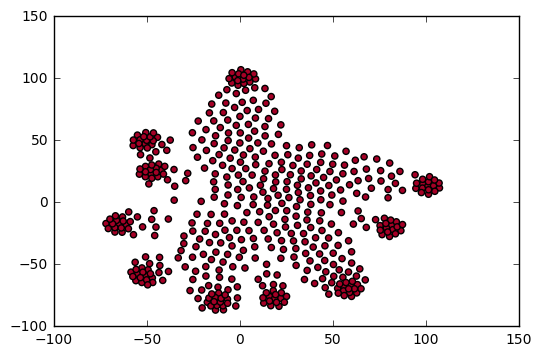

In [140]:
colors = y_train
c = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=plt.cm.RdYlGn)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(set_tw_1,
                     df_1['category'],test_size=0.2,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(X_train)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 480 / 480
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 1.100392
[t-SNE] Error after 225 iterations: 0.950442


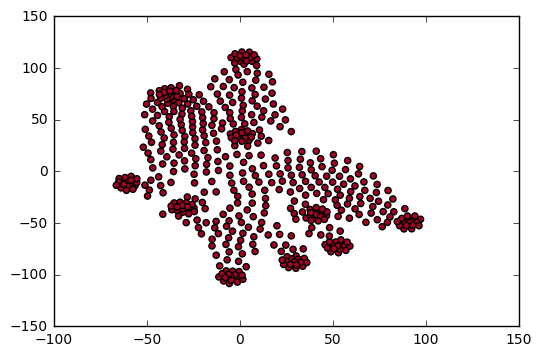

In [142]:
colors = y_train
c = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=plt.cm.RdYlGn)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(set_T_1,
                     df_1['category'],test_size=0.2,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 480 / 480
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 0.256681
[t-SNE] Error after 175 iterations: 0.711764


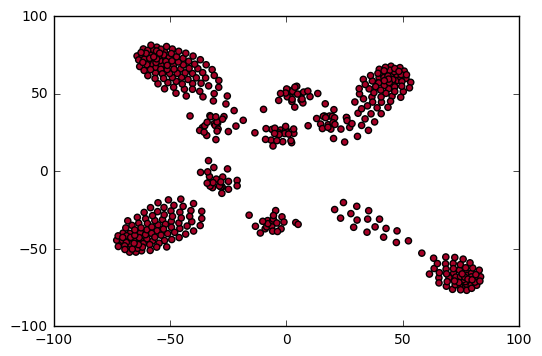

In [172]:
colors = y_train
c = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=plt.cm.RdYlGn)

In [38]:
print(len(df_2)/30)
print(48/8, ' groups in each cluster')
print(30*6, ' points in each cluster')

48.0
6.0  groups in each cluster
180  points in each cluster


In [33]:
len(dataset[(dataset['env_temp']==31.1) & (dataset['env_wet']==73.5)])

360

In [40]:
1440/30

48.0

In [50]:
dataset.columns

Index(['Unnamed: 0', 'group', 'date', 'time', 'piece', 'posi', 'speed',
       'env_temp', 'env_wet', 'T1', 'T2', 'T3', 'T4', 'T5', 'radius',
       'category'],
      dtype='object')

In [51]:
for i in range(600,2040,30):
    print(i, dataset['env_temp'][i], dataset['env_wet'][i], dataset['T1'][i], dataset['date'][i] )

600 31.1 73.5 604.0 2017-09-09 00:00:00
630 32.4 68.3 605.0 2017-09-09 00:00:00
660 32.4 68.5 605.0 2017-09-09 00:00:00
690 31.3 68.3 604.0 2017-09-09 00:00:00
720 31.1 73.5 604.0 2017-09-11 00:00:00
750 32.4 68.3 605.0 2017-09-11 00:00:00
780 32.4 68.5 605.0 2017-09-11 00:00:00
810 31.3 68.3 604.0 2017-09-11 00:00:00
840 31.1 73.5 604.0 2017-09-12 00:00:00
870 32.4 68.3 605.0 2017-09-12 00:00:00
900 32.4 68.5 605.0 2017-09-12 00:00:00
930 31.3 68.3 604.0 2017-09-12 00:00:00
960 31.1 73.5 604.0 2017-09-13 00:00:00
990 32.4 68.3 605.0 2017-09-13 00:00:00
1020 32.4 68.5 605.0 2017-09-13 00:00:00
1050 31.3 68.3 604.0 2017-09-13 00:00:00
1080 31.1 73.5 604.0 2017-09-14 00:00:00
1110 32.4 68.3 605.0 2017-09-14 00:00:00
1140 32.4 68.5 605.0 2017-09-14 00:00:00
1170 31.3 68.3 604.0 2017-09-14 00:00:00
1200 31.1 73.5 604.0 2017-09-15 00:00:00
1230 32.4 68.3 605.0 2017-09-15 00:00:00
1260 32.4 68.5 605.0 2017-09-15 00:00:00
1290 31.3 68.3 604.0 2017-09-15 00:00:00
1320 31.1 73.5 604.0 2017-09-1

In [11]:
for i in range(20):
    print(i, df_1['env_temp'][30*i], df_1['env_wet'][30*i], df_1['T2'][30*i] )

0 31.3 73.5 709.0
1 32.9 68.4 710.0
2 34.7 64.9 709.0
3 35.3 61.0 710.0
4 32.3 71.4 711.0
5 33.9 62.9 710.0
6 34.7 64.9 709.0
7 35.3 61.0 710.0
8 32.0 71.7 710.0
9 33.4 65.6 708.0
10 34.8 61.6 709.0
11 34.7 62.0 713.0
12 32.3 71.4 711.0
13 33.9 62.9 710.0
14 34.7 64.9 709.0
15 35.3 61.0 710.0
16 32.3 71.4 711.0
17 33.9 62.9 710.0
18 34.7 64.9 709.0
19 35.3 61.0 710.0


In [ ]:
'''    R ~ 600
(       0904_a 0906_a 0907_a)
(       0904_b 0906_b 0907_b)
(0901_c 0904_c 0906_c 0907_c)
(0901_d 0904_d 0906_d 0907_d)

0909
0911
0912
0913
0914
0915
0916
0918
0919
0920
0921
0922




'''

In [60]:
dataset[(dataset['env_temp']==32.3) & (dataset['env_wet']==71.4)][0:1]

,Unnamed: 0,group,date,time,piece,posi,speed,env_temp,env_wet,T1,T2,T3,T4,T5,radius,category
120,120,5.0,2017-09-04 00:00:00,08:23:00,1.0,1.0,32.34,32.3,71.4,586.0,711.0,705.0,580.0,457.0,604.9875,1


In [59]:
dataset[(dataset['env_temp']==32.3) & (dataset['env_wet']==71.4)][30:31]

,Unnamed: 0,group,date,time,piece,posi,speed,env_temp,env_wet,T1,T2,T3,T4,T5,radius,category
360,360,13.0,2017-09-06 00:00:00,08:23:00,1.0,1.0,32.34,32.3,71.4,586.0,711.0,705.0,580.0,457.0,617.118318,1


In [58]:
dataset[(dataset['env_temp']==32.3) & (dataset['env_wet']==71.4)][60:61]

,Unnamed: 0,group,date,time,piece,posi,speed,env_temp,env_wet,T1,T2,T3,T4,T5,radius,category
480,480,17.0,2017-09-07 00:00:00,08:25:00,1.0,1.0,32.34,32.3,71.4,586.0,711.0,705.0,580.0,457.0,617.748159,1


In [46]:
print(len(dataset[(dataset['env_temp']==32.3) & (dataset['env_wet']==71.4)])/30)

3.0


In [61]:
print(len(dataset[(dataset['env_temp']==34.7) & (dataset['env_wet']==64.9)])/30)

4.0


In [63]:
dataset[(dataset['env_temp']==34.7) & (dataset['env_wet']==64.9)]

,Unnamed: 0,group,date,time,piece,posi,speed,env_temp,env_wet,T1,T2,T3,T4,T5,radius,category
60,60,3.0,2017-09-01 00:00:00,13:21:00,1.0,1.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,609.045812,1
61,61,3.0,2017-09-01 00:00:00,13:21:00,1.0,2.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,613.158980,1
62,62,3.0,2017-09-01 00:00:00,13:21:00,1.0,3.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,615.236483,1
63,63,3.0,2017-09-01 00:00:00,13:21:00,1.0,4.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,621.554390,1
64,64,3.0,2017-09-01 00:00:00,13:21:00,1.0,5.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,604.987500,1
65,65,3.0,2017-09-01 00:00:00,13:21:00,1.0,6.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,617.328122,1
66,66,3.0,2017-09-01 00:00:00,13:21:00,2.0,1.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,604.987500,1
67,67,3.0,2017-09-01 00:00:00,13:21:00,2.0,2.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,609.045812,1
68,68,3.0,2017-09-01 00:00:00,13:21:00,2.0,3.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,615.236483,1
69,69,3.0,2017-09-01 00:00:00,13:21:00,2.0,4.0,32.34,34.7,64.9,579.0,709.0,706.0,580.0,461.0,613.158980,1
